# Process All Spectra

(Can get around memory limit in Jupyter Notebook)

Restoring Wavelength Template
Calculating matrix of distances between wavelengths...
Restoring DEIMOS continuum pixels
Restoring telluric mask from Kirby+ 2008...
Restoring spectral template...
Prepping cross-correlation calculation...
Beginning reduction for m15
Restoring list of m15 objects
Beginning processing of all spectra for m15
Processing spectra for object: spec1d.m15msk.007.0000034.fits
Restoring spectra #001.0000014
Restoring spectra #007.0000034
Processing spectra for object: spec1d.m15msk.000.0000006.fits
Processing spectra for object: spec1d.m15msk.008.serendip1.fits
Processing spectra for object: spec1d.m15msk.001.0000014.fits
Processing spectra for object: spec1d.m15msk.004.0000029.fits
Processing spectra for object: spec1d.m15msk.005.0000030.fits
Processing spectra for object: spec1d.m15msk.016.0010294.fits
Restoring spectra #008.serendip1
Processing spectra for object: spec1d.m15msk.010.0010510.fits
Processing spectra for object: spec1d.m15msk.017.0010244.fits
Process

Interpolating spectra #012.0010152
Applying telluric mask for spectra 012.0010152
Finding radial velocity from CCF for spectra #012.0010152
Interpolating spectra #009.0010230
Interpolating spectra #025.0010581
Applying telluric mask for spectra 009.0010230
Finding radial velocity from CCF for spectra #009.0010230
Applying telluric mask for spectra 025.0010581
Finding radial velocity from CCF for spectra #025.0010581
Interpolating spectra #024.serendip1
Applying telluric mask for spectra 024.serendip1
Finding radial velocity from CCF for spectra #024.serendip1
Interpolating spectra #017.0010244
Interpolating spectra #019.0010495
Applying telluric mask for spectra 017.0010244
Finding radial velocity from CCF for spectra #017.0010244
Applying telluric mask for spectra 019.0010495
Finding radial velocity from CCF for spectra #019.0010495
Interpolating spectra #015.0010330
Applying telluric mask for spectra 015.0010330
Finding radial velocity from CCF for spectra #015.0010330
Interpolating 

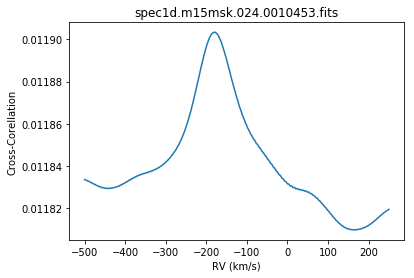

024.0010453 has Radial Velocity = -180
Shifting spectra 024.0010453 to rest frame
Normalizing spectra 024.0010453


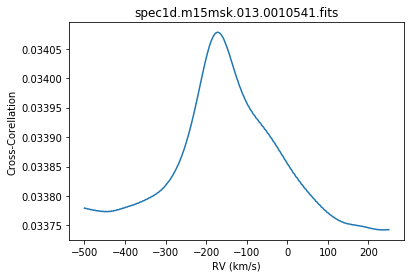

013.0010541 has Radial Velocity = -172
Calculating weights...
Shifting spectra 013.0010541 to rest frame
Normalizing spectra 013.0010541
Calculating weights...


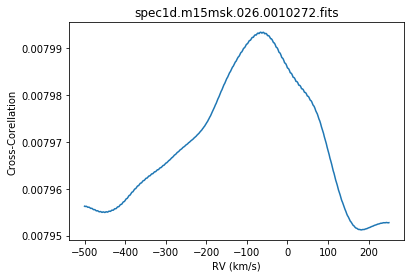

026.0010272 has Radial Velocity = -66


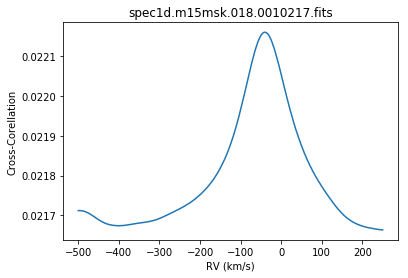

Shifting spectra 026.0010272 to rest frame
018.0010217 has Radial Velocity = -40
Shifting spectra 018.0010217 to rest frame
Normalizing spectra 018.0010217
Normalizing spectra 026.0010272
Calculating weights...
Calculating weights...


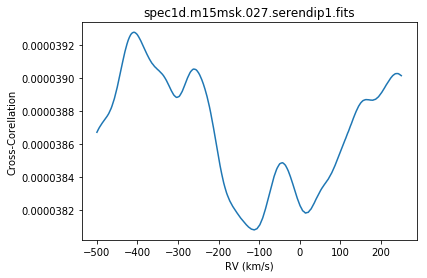

027.serendip1 has Radial Velocity = -409
Shifting spectra 027.serendip1 to rest frame
Normalizing spectra 027.serendip1
Calculating weights...


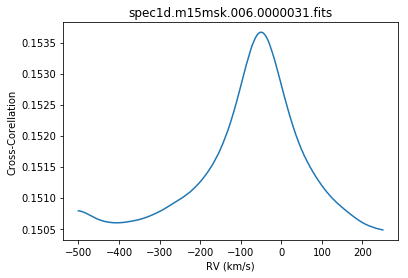

006.0000031 has Radial Velocity = -50
Shifting spectra 006.0000031 to rest frame
Normalizing spectra 006.0000031
Calculating weights...


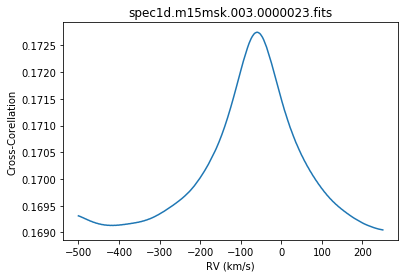

003.0000023 has Radial Velocity = -59
Shifting spectra 003.0000023 to rest frame
Normalizing spectra 003.0000023
Calculating weights...


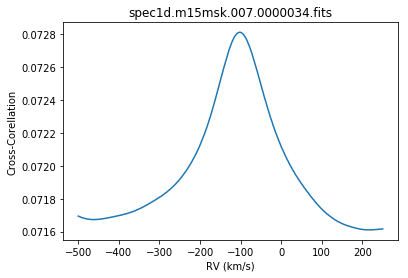

007.0000034 has Radial Velocity = -101


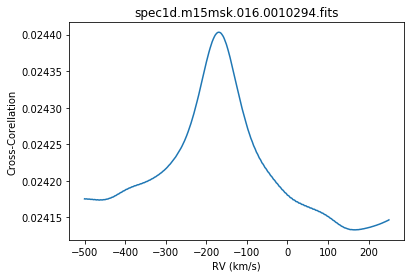

Shifting spectra 007.0000034 to rest frame
016.0010294 has Radial Velocity = -170
Normalizing spectra 007.0000034
Shifting spectra 016.0010294 to rest frame


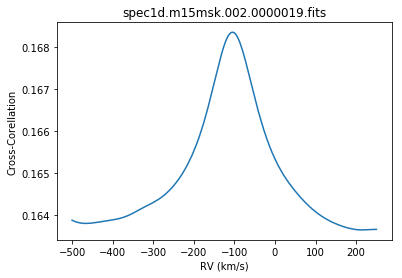

Normalizing spectra 016.0010294
Calculating weights...
002.0000019 has Radial Velocity = -104
Calculating weights...
Shifting spectra 002.0000019 to rest frame
Normalizing spectra 002.0000019
Calculating weights...


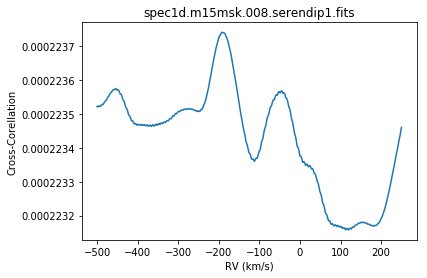

008.serendip1 has Radial Velocity = -192
Shifting spectra 008.serendip1 to rest frame
Normalizing spectra 008.serendip1


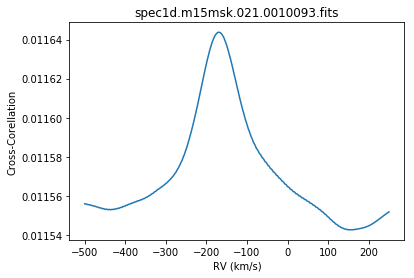

Calculating weights...


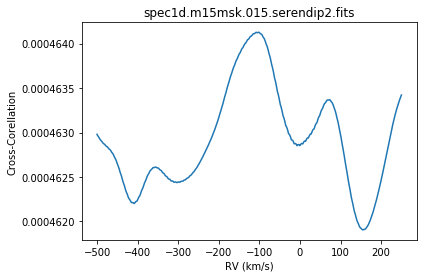

021.0010093 has Radial Velocity = -171
015.serendip2 has Radial Velocity = -101
Shifting spectra 021.0010093 to rest frame
Shifting spectra 015.serendip2 to rest frame
Normalizing spectra 021.0010093
Normalizing spectra 015.serendip2
Calculating weights...
Calculating weights...


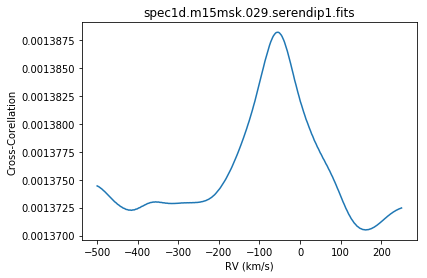

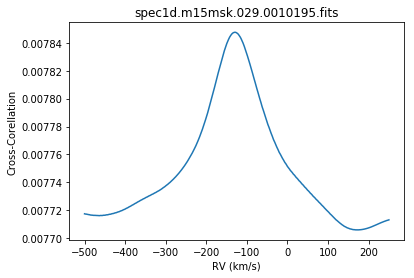

029.serendip1 has Radial Velocity = -54


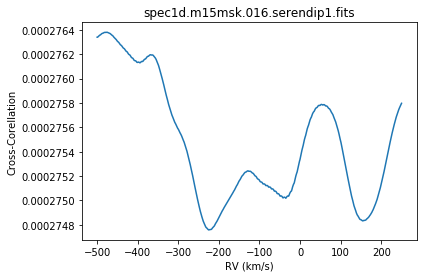

Shifting spectra 029.serendip1 to rest frame
029.0010195 has Radial Velocity = -130
Shifting spectra 029.0010195 to rest frame
016.serendip1 has Radial Velocity = -476
Normalizing spectra 029.serendip1
Normalizing spectra 029.0010195
Shifting spectra 016.serendip1 to rest frame
Calculating weights...
Normalizing spectra 016.serendip1
Calculating weights...
Calculating weights...


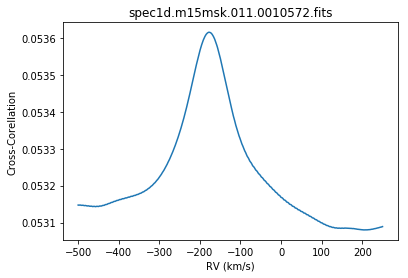

011.0010572 has Radial Velocity = -178
Shifting spectra 011.0010572 to rest frame
Normalizing spectra 011.0010572
Calculating weights...


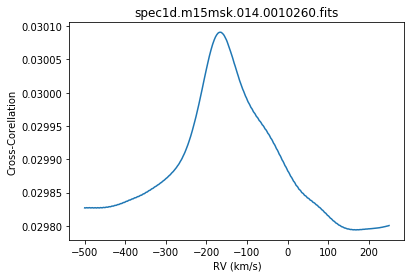

014.0010260 has Radial Velocity = -166
Shifting spectra 014.0010260 to rest frame


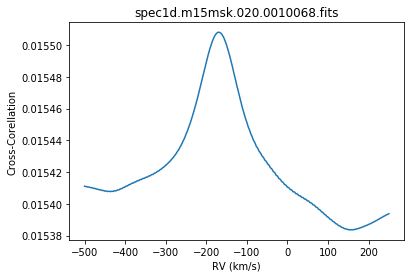

Normalizing spectra 014.0010260


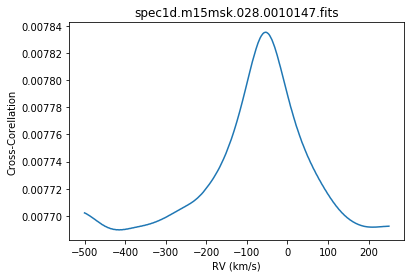

Calculating weights...
020.0010068 has Radial Velocity = -171
028.0010147 has Radial Velocity = -53
Shifting spectra 020.0010068 to rest frame
Shifting spectra 028.0010147 to rest frame
Normalizing spectra 020.0010068
Normalizing spectra 028.0010147


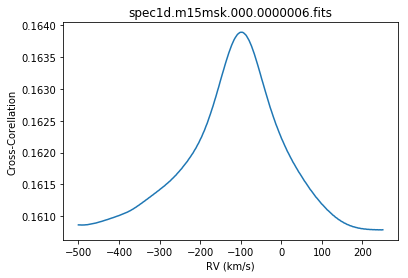

Calculating weights...


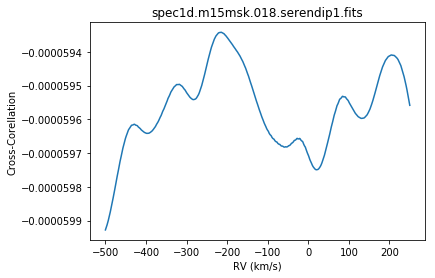

018.serendip1 has Radial Velocity = -215


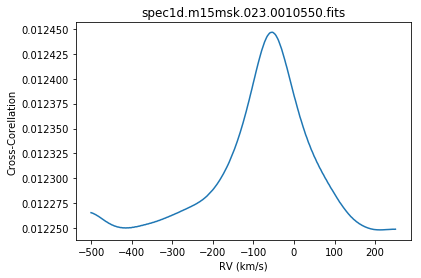

Calculating weights...
Shifting spectra 018.serendip1 to rest frame


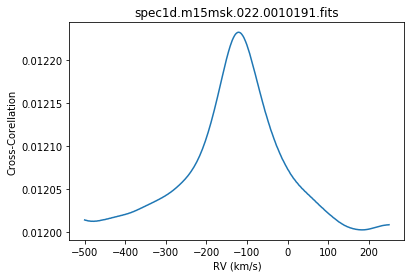

023.0010550 has Radial Velocity = -53
000.0000006 has Radial Velocity = -97
Shifting spectra 000.0000006 to rest frame
022.0010191 has Radial Velocity = -120
Normalizing spectra 000.0000006
Shifting spectra 023.0010550 to rest frame
Normalizing spectra 023.0010550
Shifting spectra 022.0010191 to rest frame
Calculating weights...
Normalizing spectra 022.0010191
Calculating weights...
Normalizing spectra 018.serendip1


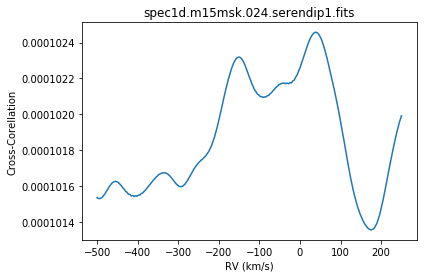

Calculating weights...


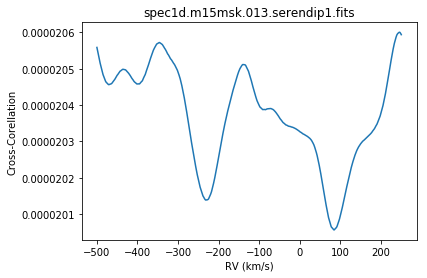

Calculating weights...
024.serendip1 has Radial Velocity = 39


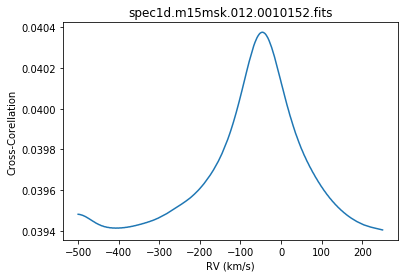

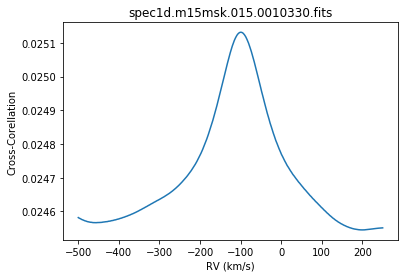

013.serendip1 has Radial Velocity = 246
012.0010152 has Radial Velocity = -46
Shifting spectra 013.serendip1 to rest frame


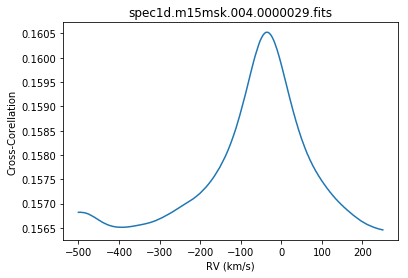

Shifting spectra 012.0010152 to rest frame
004.0000029 has Radial Velocity = -35
015.0010330 has Radial Velocity = -99
Normalizing spectra 012.0010152
Shifting spectra 004.0000029 to rest frame
Shifting spectra 015.0010330 to rest frame
Normalizing spectra 004.0000029
Calculating weights...
Normalizing spectra 013.serendip1
Normalizing spectra 015.0010330


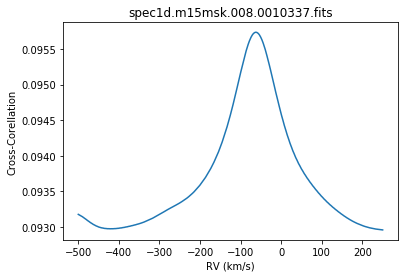

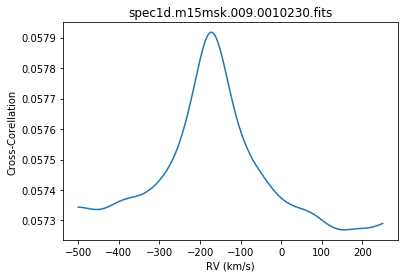

Calculating weights...
Calculating weights...
008.0010337 has Radial Velocity = -62
009.0010230 has Radial Velocity = -172
Calculating weights...
Shifting spectra 024.serendip1 to rest frame
Normalizing spectra 024.serendip1


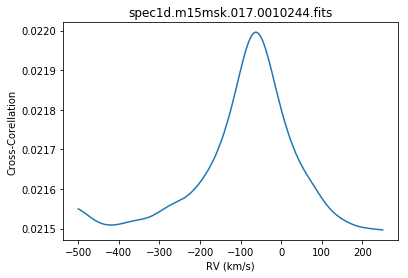

Shifting spectra 009.0010230 to rest frame
Calculating weights...
Shifting spectra 008.0010337 to rest frame
017.0010244 has Radial Velocity = -62
Shifting spectra 017.0010244 to rest frame


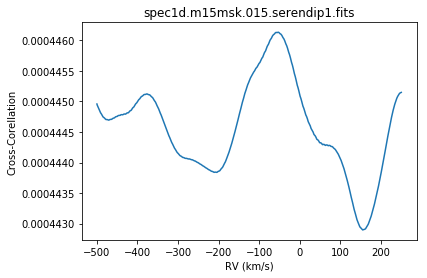

Normalizing spectra 017.0010244
015.serendip1 has Radial Velocity = -53
Calculating weights...
Shifting spectra 015.serendip1 to rest frame
Normalizing spectra 008.0010337
Normalizing spectra 015.serendip1
Normalizing spectra 009.0010230
Calculating weights...
Calculating weights...
Calculating weights...


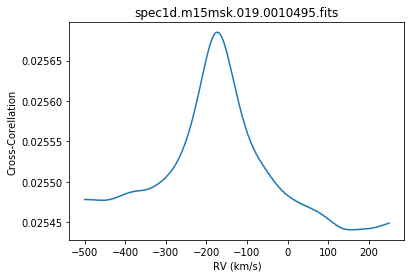

019.0010495 has Radial Velocity = -174


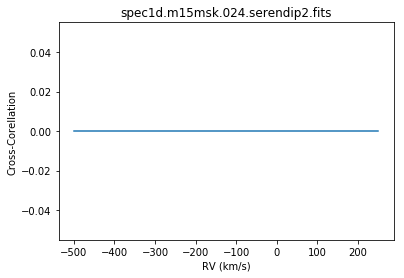

Shifting spectra 019.0010495 to rest frame
024.serendip2 has Radial Velocity = -500
Normalizing spectra 019.0010495
Calculating weights...
Shifting spectra 024.serendip2 to rest frame
Normalizing spectra 024.serendip2


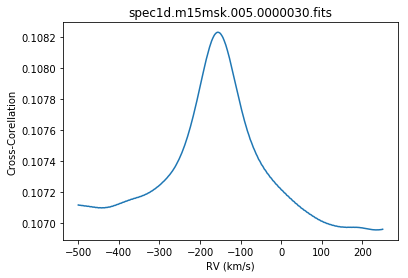

Calculating weights...
005.0000030 has Radial Velocity = -157


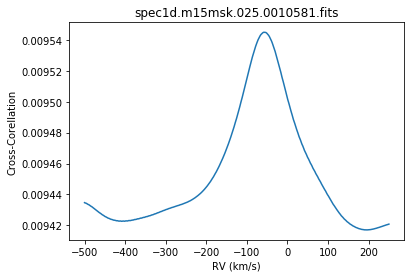

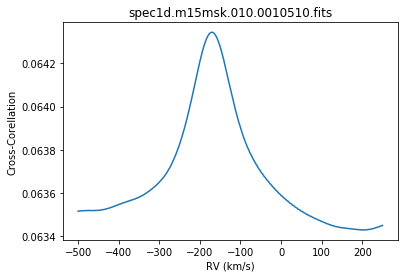

Shifting spectra 005.0000030 to rest frame


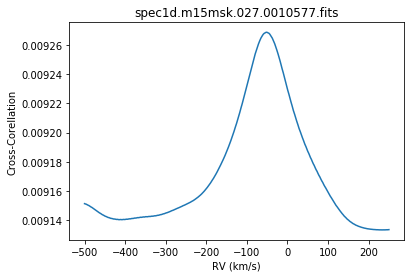

025.0010581 has Radial Velocity = -57
010.0010510 has Radial Velocity = -171
Normalizing spectra 005.0000030
Shifting spectra 010.0010510 to rest frame
027.0010577 has Radial Velocity = -51
Calculating weights...
Normalizing spectra 010.0010510
Shifting spectra 027.0010577 to rest frame
Shifting spectra 025.0010581 to rest frame
Calculating weights...


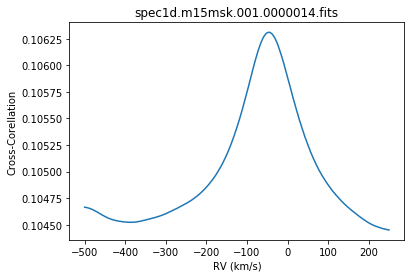

Normalizing spectra 027.0010577
Normalizing spectra 025.0010581
Calculating weights...
Calculating weights...
001.0000014 has Radial Velocity = -45
Shifting spectra 001.0000014 to rest frame
Normalizing spectra 001.0000014
Calculating weights...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.030.0010442.fits
Restoring spectra #030.0010442
Calculating continuum...
Continuum calculation complete!
Interpolating spectra #030.0010442
Applying telluric mask for spectra 030.0010442
Finding radial velocity from CCF for spectra #030.0010442


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.030.serendip1.fits
Restoring spectra #030.serendip1
Interpolating spectra #030.serendip1
Applying telluric mask for spectra 030.serendip1


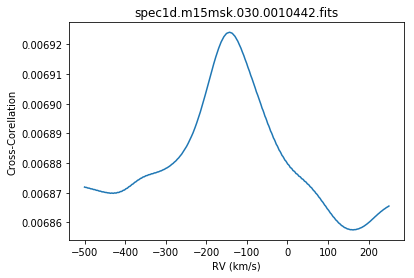

Finding radial velocity from CCF for spectra #030.serendip1
030.0010442 has Radial Velocity = -144
Shifting spectra 030.0010442 to rest frame
Normalizing spectra 030.0010442
Continuum calculation complete!
Calculating weights...
Continuum calculation complete!


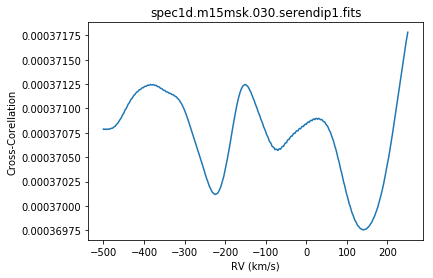

030.serendip1 has Radial Velocity = 250
Shifting spectra 030.serendip1 to rest frame
Normalizing spectra 030.serendip1
Calculating weights...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.031.0010425.fits
Restoring spectra #031.0010425
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.031.serendip1.fits
Restoring spectra #031.serendip1
Continuum calculation complete!
Interpolating spectra #031.0010425
Applying telluric mask for spectra 031.0010425
Finding radial velocity from CCF for spectra #031.0010425
Interpolating spectra #031.serendip1
Applying telluric mask for spectra 031.serendip1
Finding radial velocity from CCF for spectra #031.serendip1


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.031.serendip2.fits
Restoring spectra #031.serendip2
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.032.0010123.fits
Restoring spectra #032.0010123


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.033.0010107.fits
Calculating continuum...
Restoring spectra #033.0010107


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.034.0010494.fits
Restoring spectra #034.0010494


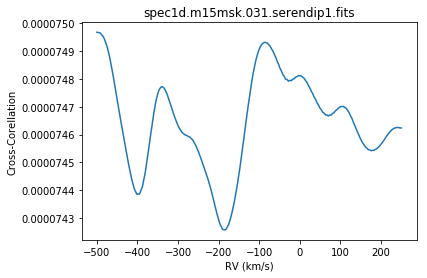

031.serendip1 has Radial Velocity = -499
Shifting spectra 031.serendip1 to rest frame
Normalizing spectra 031.serendip1
Calculating weights...
Interpolating spectra #031.serendip2
Applying telluric mask for spectra 031.serendip2
Finding radial velocity from CCF for spectra #031.serendip2


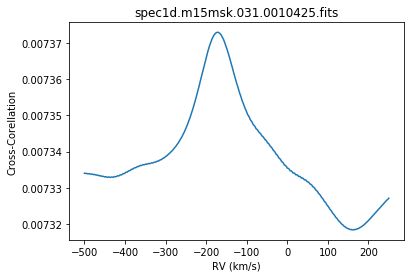

Calculating continuum...
Continuum calculation complete!
Interpolating spectra #032.0010123
Applying telluric mask for spectra 032.0010123
Finding radial velocity from CCF for spectra #032.0010123
031.0010425 has Radial Velocity = -172
Interpolating spectra #033.0010107
Applying telluric mask for spectra 033.0010107
Finding radial velocity from CCF for spectra #033.0010107
Shifting spectra 031.0010425 to rest frame
Normalizing spectra 031.0010425
Calculating weights...
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.035.0010452.fits
Restoring spectra #035.0010452
Interpolating spectra #034.0010494
Applying telluric mask for spectra 034.0010494
Finding radial velocity from CCF for spectra #034.0010494


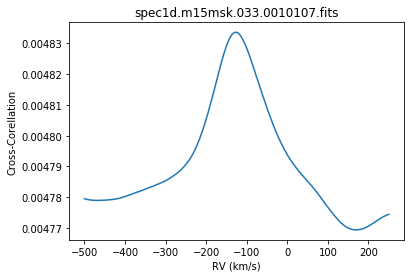

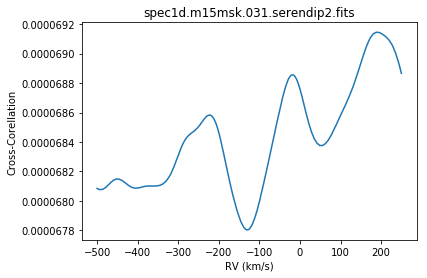

033.0010107 has Radial Velocity = -129


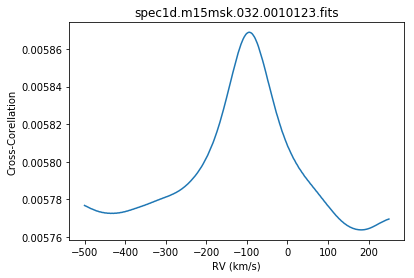

032.0010123 has Radial Velocity = -94
Shifting spectra 032.0010123 to rest frame
Normalizing spectra 032.0010123
Calculating weights...
Shifting spectra 033.0010107 to rest frame
031.serendip2 has Radial Velocity = 189
Normalizing spectra 033.0010107
Interpolating spectra #035.0010452
Applying telluric mask for spectra 035.0010452
Calculating continuum...
Calculating weights...
Shifting spectra 031.serendip2 to rest frame
Finding radial velocity from CCF for spectra #035.0010452
Normalizing spectra 031.serendip2
Calculating weights...
Continuum calculation complete!


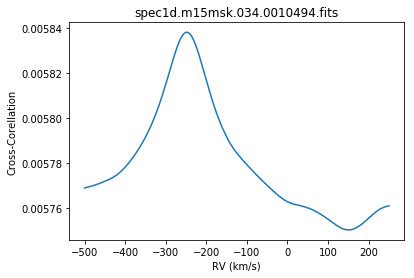

034.0010494 has Radial Velocity = -249
Shifting spectra 034.0010494 to rest frame
Normalizing spectra 034.0010494
Calculating weights...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.035.serendip1.fits
Restoring spectra #035.serendip1
Calculating continuum...


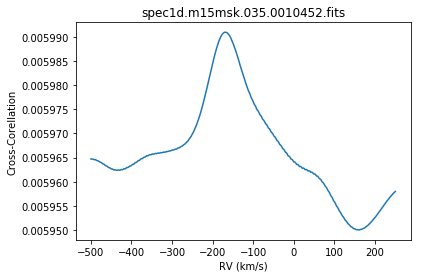

035.0010452 has Radial Velocity = -170
Shifting spectra 035.0010452 to rest frame
Normalizing spectra 035.0010452
Calculating weights...
Interpolating spectra #035.serendip1
Applying telluric mask for spectra 035.serendip1
Finding radial velocity from CCF for spectra #035.serendip1
Calculating continuum...
Calculating continuum...


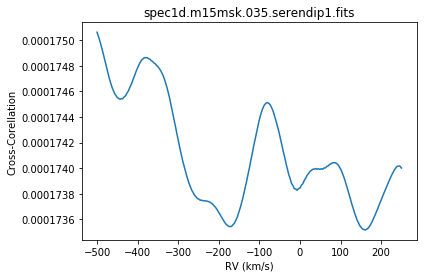

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.036.0010207.fits
035.serendip1 has Radial Velocity = -500
Shifting spectra 035.serendip1 to rest frame
Normalizing spectra 035.serendip1
Calculating weights...
Restoring spectra #036.0010207
Interpolating spectra #036.0010207
Continuum calculation complete!
Applying telluric mask for spectra 036.0010207
Finding radial velocity from CCF for spectra #036.0010207
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Processing spectra for object: spec1d.m15msk.036.serendip1.fits
Restoring spectra #036.serendip1


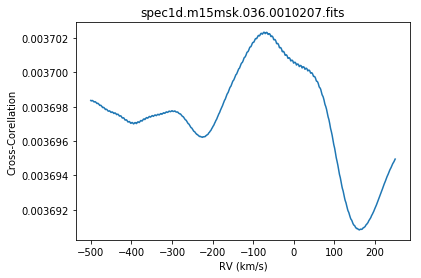

036.0010207 has Radial Velocity = -73
Shifting spectra 036.0010207 to rest frame
Calculating continuum...
Normalizing spectra 036.0010207
Calculating weights...
Processing spectra for object: spec1d.m15msk.037.0010066.fits
Interpolating spectra #036.serendip1
Restoring spectra #037.0010066
Continuum calculation complete!
Applying telluric mask for spectra 036.serendip1
Finding radial velocity from CCF for spectra #036.serendip1
Calculating continuum...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.037.serendip1.fits
Restoring spectra #037.serendip1
Calculating continuum...
Interpolating spectra #037.0010066
Applying telluric mask for spectra 037.0010066
Finding radial velocity from CCF for spectra #037.0010066
Processing spectra for object: spec1d.m15msk.038.0010176.fits
Restoring spectra #038.0010176
Interpolating spectra #037.serendip1
Applying telluric mask for spectra 037.serendip1
Finding radial velocity from CCF for spectra #037.serendip1
Continuum calculation complete!
Continuum calculation complete!


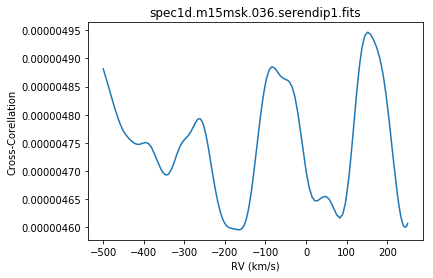

Calculating continuum...
036.serendip1 has Radial Velocity = 152


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.038.serendip1.fits
Continuum calculation complete!
Shifting spectra 036.serendip1 to rest frame
Restoring spectra #038.serendip1
Normalizing spectra 036.serendip1
Interpolating spectra #038.0010176
Calculating weights...
Applying telluric mask for spectra 038.0010176
Finding radial velocity from CCF for spectra #038.0010176
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.039.0010405.fits
Restoring spectra #039.0010405


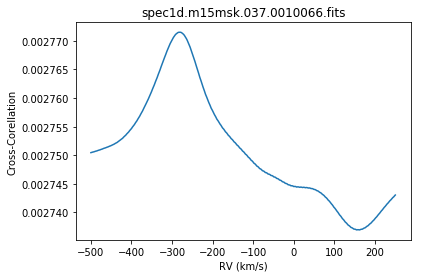

037.0010066 has Radial Velocity = -280
Shifting spectra 037.0010066 to rest frame
Normalizing spectra 037.0010066
Calculating weights...


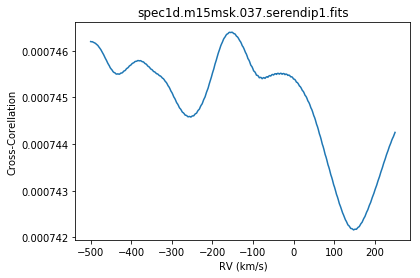

Interpolating spectra #038.serendip1
Applying telluric mask for spectra 038.serendip1
Finding radial velocity from CCF for spectra #038.serendip1
037.serendip1 has Radial Velocity = -153
Shifting spectra 037.serendip1 to rest frame
Normalizing spectra 037.serendip1
Calculating weights...
Interpolating spectra #039.0010405
Applying telluric mask for spectra 039.0010405
Finding radial velocity from CCF for spectra #039.0010405


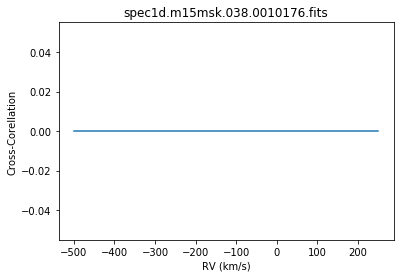

038.0010176 has Radial Velocity = -500
Shifting spectra 038.0010176 to rest frame
Normalizing spectra 038.0010176
Calculating weights...


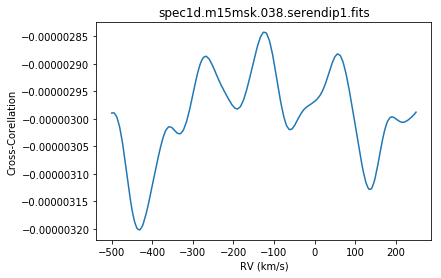

038.serendip1 has Radial Velocity = -126
Shifting spectra 038.serendip1 to rest frame
Normalizing spectra 038.serendip1
Calculating weights...


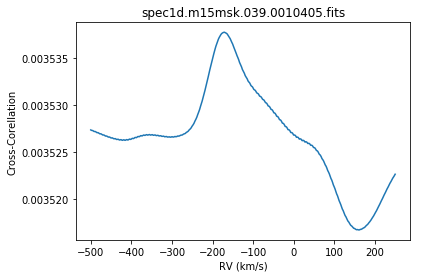

039.0010405 has Radial Velocity = -172
Shifting spectra 039.0010405 to rest frame
Normalizing spectra 039.0010405
Calculating weights...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.039.serendip1.fits
Restoring spectra #039.serendip1
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.040.0010487.fits
Restoring spectra #040.0010487
Processing spectra for object: spec1d.m15msk.040.serendip1.fits
Restoring spectra #040.serendip1


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Interpolating spectra #039.serendip1
Applying telluric mask for spectra 039.serendip1
Processing spectra for object: spec1d.m15msk.042.0010526.fits
Processing spectra for object: spec1d.m15msk.041.0010215.fits
Restoring spectra #041.0010215
Restoring spectra #042.0010526
Finding radial velocity from CCF for spectra #039.serendip1
Interpolating spectra #040.0010487
Applying telluric mask for spectra 040.0010487
Finding radial velocity from CCF for spectra #040.0010487
Interpolating spectra #040.serendip1
Applying telluric mask for spectra 040.serendip1
Interpolating spectra #041.0010215
Applying telluric mask for spectra 041.0010215
Interpolating spectra #042.0010526
Finding radial velocity from CCF for spectra #040.serendip1
Applying telluric mask for spectra 042.0010526
Finding radial velocity from CCF for spectra #042.0010526
Finding radial velocity from CCF for spectra #041.0010215
Continuum calculation complete!


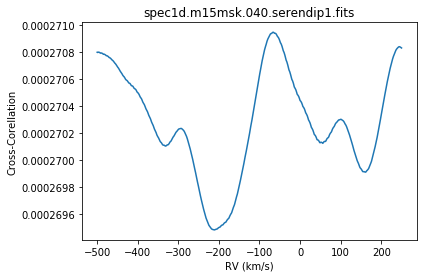

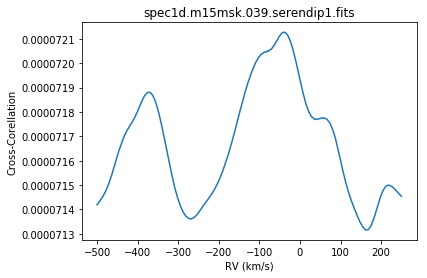

040.serendip1 has Radial Velocity = -66
Shifting spectra 040.serendip1 to rest frame
Normalizing spectra 040.serendip1
Calculating weights...
039.serendip1 has Radial Velocity = -38


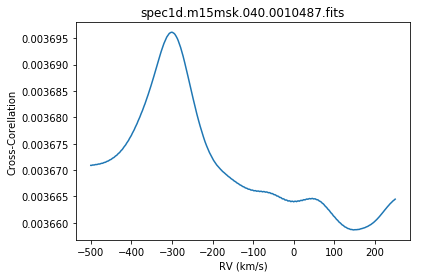

040.0010487 has Radial Velocity = -301
Shifting spectra 040.0010487 to rest frame
Normalizing spectra 040.0010487
Calculating weights...
Shifting spectra 039.serendip1 to rest frame
Normalizing spectra 039.serendip1
Calculating weights...


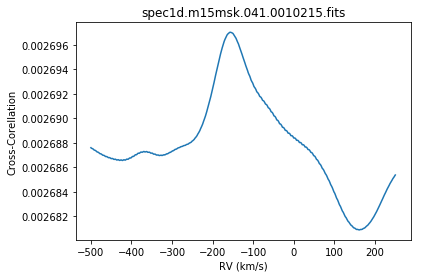

041.0010215 has Radial Velocity = -157
Shifting spectra 041.0010215 to rest frame


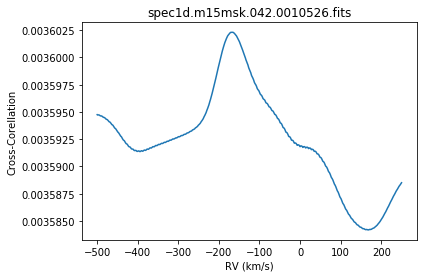

Normalizing spectra 041.0010215
Calculating weights...
042.0010526 has Radial Velocity = -168
Shifting spectra 042.0010526 to rest frame


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.043.0010525.fits
Restoring spectra #043.0010525
Normalizing spectra 042.0010526
Calculating weights...
Interpolating spectra #043.0010525
Applying telluric mask for spectra 043.0010525
Finding radial velocity from CCF for spectra #043.0010525
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.043.serendip1.fits
Restoring spectra #043.serendip1
Interpolating spectra #043.serendip1
Applying telluric mask for spectra 043.serendip1
Finding radial velocity from CCF for spectra #043.serendip1


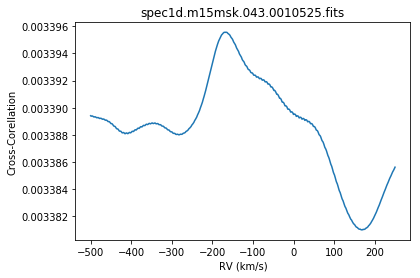

043.0010525 has Radial Velocity = -168
Shifting spectra 043.0010525 to rest frame
Normalizing spectra 043.0010525
Calculating weights...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.043.serendip2.fits
Restoring spectra #043.serendip2


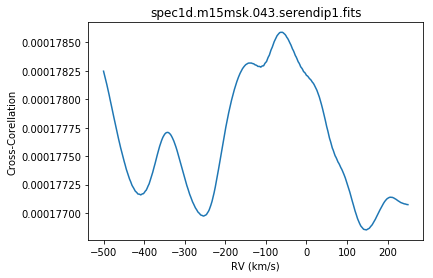

043.serendip1 has Radial Velocity = -60
Shifting spectra 043.serendip1 to rest frame
Normalizing spectra 043.serendip1
Calculating weights...
Interpolating spectra #043.serendip2
Applying telluric mask for spectra 043.serendip2
Finding radial velocity from CCF for spectra #043.serendip2
Continuum calculation complete!


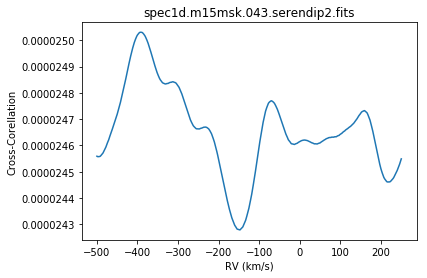

043.serendip2 has Radial Velocity = -393
Shifting spectra 043.serendip2 to rest frame
Normalizing spectra 043.serendip2
Calculating weights...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.044.0010111.fits
Restoring spectra #044.0010111
Continuum calculation complete!
Continuum calculation complete!
Interpolating spectra #044.0010111
Applying telluric mask for spectra 044.0010111
Finding radial velocity from CCF for spectra #044.0010111
Continuum calculation complete!
Continuum calculation complete!


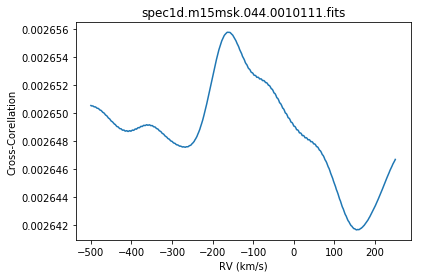

044.0010111 has Radial Velocity = -161
Shifting spectra 044.0010111 to rest frame
Normalizing spectra 044.0010111
Calculating weights...


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.045.0010417.fits
Restoring spectra #045.0010417
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.046.0010570.fits


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Restoring spectra #046.0010570
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.047.0010539.fits
Restoring spectra #047.0010539
Continuum calculation complete!
Interpolating spectra #045.0010417
Applying telluric mask for spectra 045.0010417
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Finding radial velocity from CCF for spectra #045.0010417
Interpolating spectra #046.0010570
Applying telluric mask for spectra 046.0010570
Processing spectra for object: spec1d.m15msk.048.0010537.fits
Continuum calculation complete!
Finding radial velocity from CCF for spectra #046.0010570
Restoring spectra #048.0010537
Interpolating spectra #047.0010539
Continuum calculation complete!
Applying telluric mask for spectra 047.0010539
Finding radial velocity from CCF for spectra #047.0010539
Continuum calculation complete!
Interpolating spectra #048.0010537
Applying telluric mask for spectra 048.0010537
Continuum calculation complete!


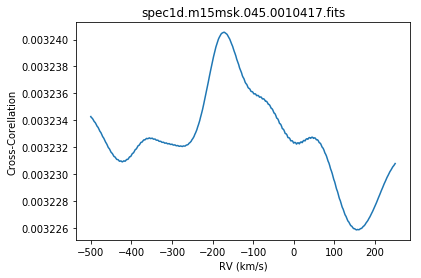

045.0010417 has Radial Velocity = -172
Shifting spectra 045.0010417 to rest frame
Finding radial velocity from CCF for spectra #048.0010537
Normalizing spectra 045.0010417
Calculating weights...


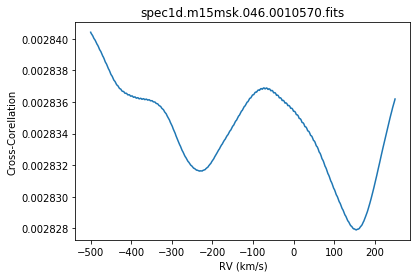

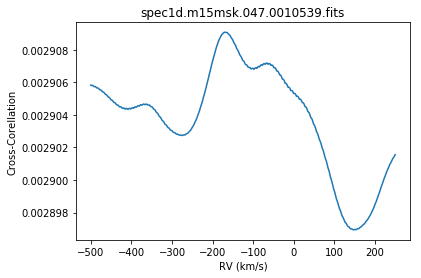

047.0010539 has Radial Velocity = -171
Shifting spectra 047.0010539 to rest frame
Normalizing spectra 047.0010539
046.0010570 has Radial Velocity = -500
Calculating weights...
Shifting spectra 046.0010570 to rest frame
Normalizing spectra 046.0010570


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Calculating weights...
Processing spectra for object: spec1d.m15msk.049.0010155.fits
Restoring spectra #049.0010155


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.050.0010504.fits
Restoring spectra #050.0010504


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


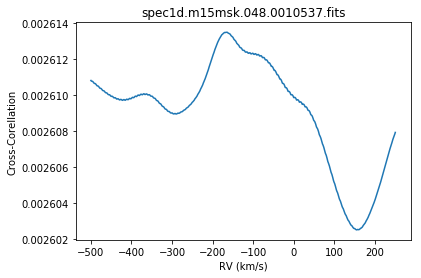

Processing spectra for object: spec1d.m15msk.051.0010229.fits
Restoring spectra #051.0010229
048.0010537 has Radial Velocity = -165
Shifting spectra 048.0010537 to rest frame
Normalizing spectra 048.0010537
Interpolating spectra #049.0010155
Calculating weights...
Applying telluric mask for spectra 049.0010155
Finding radial velocity from CCF for spectra #049.0010155


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.052.0010189.fits
Restoring spectra #052.0010189
Interpolating spectra #050.0010504
Applying telluric mask for spectra 050.0010504
Finding radial velocity from CCF for spectra #050.0010504


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.053.0010199.fits
Restoring spectra #053.0010199


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Interpolating spectra #051.0010229
Applying telluric mask for spectra 051.0010229
Finding radial velocity from CCF for spectra #051.0010229
Processing spectra for object: spec1d.m15msk.053.serendip1.fits
Restoring spectra #053.serendip1
Processing spectra for object: spec1d.m15msk.054.0010345.fits
Restoring spectra #054.0010345
Interpolating spectra #052.0010189


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Applying telluric mask for spectra 052.0010189
Finding radial velocity from CCF for spectra #052.0010189
Processing spectra for object: spec1d.m15msk.055.0010100.fits
Restoring spectra #055.0010100
Interpolating spectra #053.0010199
Interpolating spectra #054.0010345
Applying telluric mask for spectra 054.0010345
Finding radial velocity from CCF for spectra #054.0010345
Applying telluric mask for spectra 053.0010199
Finding radial velocity from CCF for spectra #053.0010199


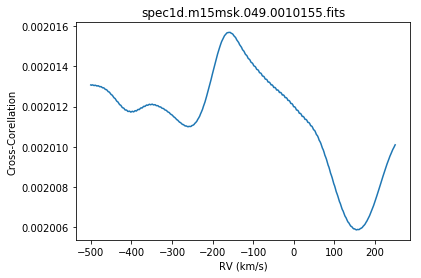

049.0010155 has Radial Velocity = -158
Shifting spectra 049.0010155 to rest frame
Normalizing spectra 049.0010155
Calculating weights...
Interpolating spectra #053.serendip1
Applying telluric mask for spectra 053.serendip1
Finding radial velocity from CCF for spectra #053.serendip1


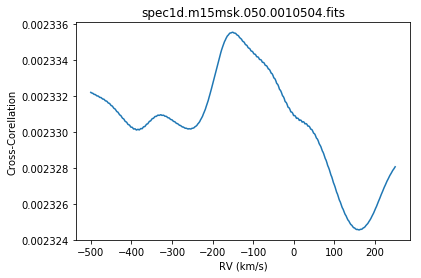

050.0010504 has Radial Velocity = -151
Shifting spectra 050.0010504 to rest frame
Normalizing spectra 050.0010504
Calculating weights...


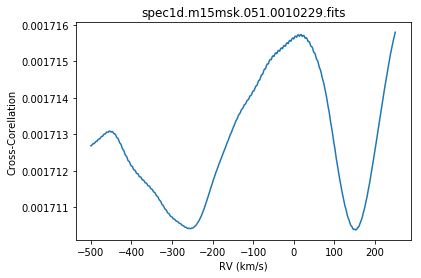

Interpolating spectra #055.0010100
051.0010229 has Radial Velocity = 250
Shifting spectra 051.0010229 to rest frame
Normalizing spectra 051.0010229
Applying telluric mask for spectra 055.0010100
Calculating weights...
Finding radial velocity from CCF for spectra #055.0010100


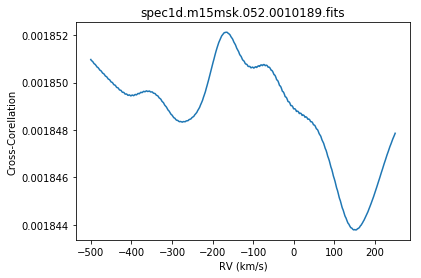

052.0010189 has Radial Velocity = -165
Shifting spectra 052.0010189 to rest frame
Normalizing spectra 052.0010189
Calculating weights...


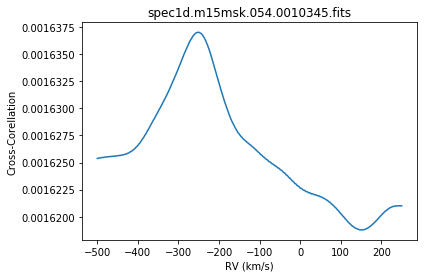

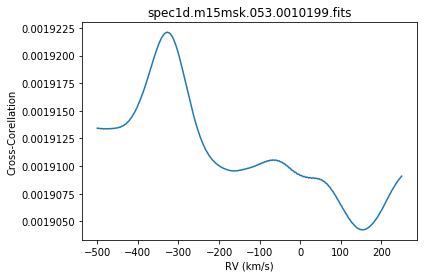

054.0010345 has Radial Velocity = -251
053.0010199 has Radial Velocity = -328
Shifting spectra 053.0010199 to rest frame


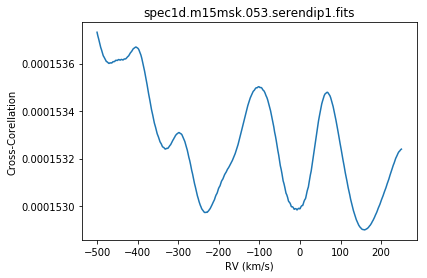

Shifting spectra 054.0010345 to rest frame
Normalizing spectra 054.0010345
Calculating weights...
053.serendip1 has Radial Velocity = -500
Normalizing spectra 053.0010199
Shifting spectra 053.serendip1 to rest frame
Normalizing spectra 053.serendip1
Calculating weights...
Calculating weights...


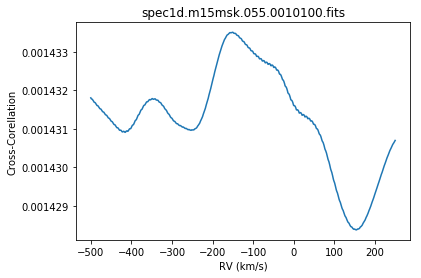

055.0010100 has Radial Velocity = -151
Shifting spectra 055.0010100 to rest frame
Normalizing spectra 055.0010100
Calculating weights...
Continuum calculation complete!
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.055.serendip1.fits
Restoring spectra #055.serendip1
Interpolating spectra #055.serendip1


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Applying telluric mask for spectra 055.serendip1
Finding radial velocity from CCF for spectra #055.serendip1
Processing spectra for object: spec1d.m15msk.056.0010351.fits
Restoring spectra #056.0010351
Interpolating spectra #056.0010351
Applying telluric mask for spectra 056.0010351
Finding radial velocity from CCF for spectra #056.0010351


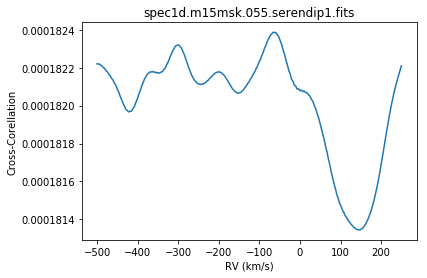

055.serendip1 has Radial Velocity = -65
Shifting spectra 055.serendip1 to rest frame
Normalizing spectra 055.serendip1
Calculating weights...


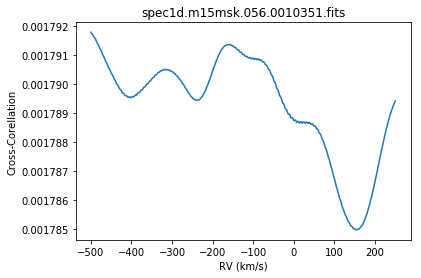

056.0010351 has Radial Velocity = -500
Shifting spectra 056.0010351 to rest frame
Normalizing spectra 056.0010351
Calculating weights...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Processing spectra for object: spec1d.m15msk.057.0010261.fits
Restoring spectra #057.0010261
Calculating continuum...
Interpolating spectra #057.0010261
Applying telluric mask for spectra 057.0010261
Finding radial velocity from CCF for spectra #057.0010261
Calculating continuum...


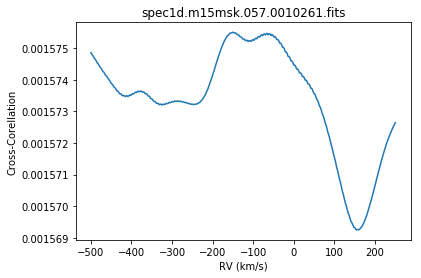

057.0010261 has Radial Velocity = -151
Shifting spectra 057.0010261 to rest frame
Normalizing spectra 057.0010261
Calculating weights...
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.059.0010134.fits
Restoring spectra #059.0010134
Processing spectra for object: spec1d.m15msk.058.0010080.fits
Restoring spectra #058.0010080
Calculating continuum...
Processing spectra for object: spec1d.m15msk.060.0010478.fits
Restoring spectra #060.0010478
Interpolating spectra #059.0010134
Applying telluric mask for spectra 059.0010134
Finding radial velocity from CCF for spectra #059.0010134
Calculating continuum...
Interpolating spectra #058.0010080
Applying telluric mask for spectra 058.0010080
Finding radial velocity from CCF for spectra #058.0010080
Interpolating spectra #060.0010478
Applying telluric mask for spectra 060.0010478
Finding radial velo

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.060.serendip1.fits
Restoring spectra #060.serendip1


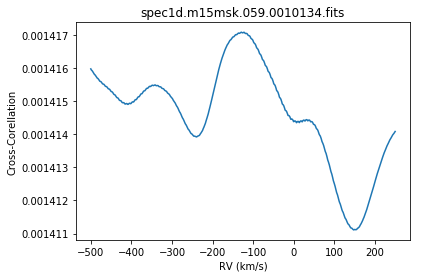

059.0010134 has Radial Velocity = -130
Shifting spectra 059.0010134 to rest frame
Normalizing spectra 059.0010134
Calculating weights...
Continuum calculation complete!


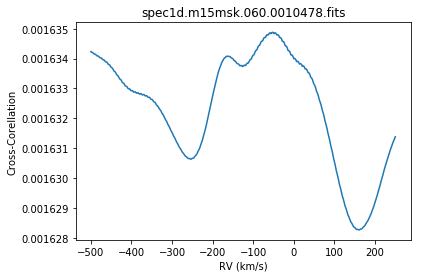

Calculating continuum...
Calculating continuum...
060.0010478 has Radial Velocity = -52


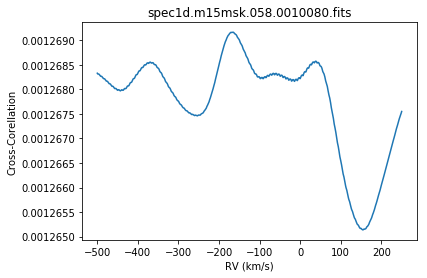

Shifting spectra 060.0010478 to rest frame
058.0010080 has Radial Velocity = -166
Normalizing spectra 060.0010478
Continuum calculation complete!
Calculating weights...
Interpolating spectra #060.serendip1
Shifting spectra 058.0010080 to rest frame
Applying telluric mask for spectra 060.serendip1
Normalizing spectra 058.0010080
Calculating weights...
Finding radial velocity from CCF for spectra #060.serendip1
Calculating continuum...
Calculating continuum...


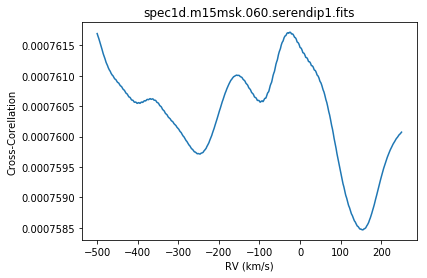

060.serendip1 has Radial Velocity = -25
Shifting spectra 060.serendip1 to rest frame
Normalizing spectra 060.serendip1
Calculating weights...
Processing spectra for object: spec1d.m15msk.061.0010053.fits
Restoring spectra #061.0010053
Interpolating spectra #061.0010053
Applying telluric mask for spectra 061.0010053
Finding radial velocity from CCF for spectra #061.0010053
Processing spectra for object: spec1d.m15msk.062.0010138.fits
Restoring spectra #062.0010138
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Interpolating spectra #062.0010138
Applying telluric mask for spectra 062.0010138
Finding radial velocity from CCF for spectra #062.0010138
Calculating continuum...
Calculating continuum...


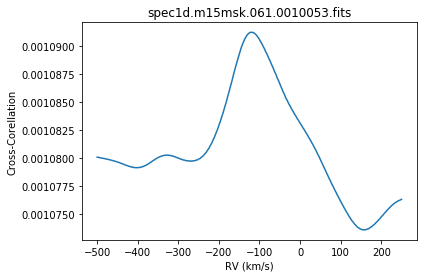

061.0010053 has Radial Velocity = -118
Shifting spectra 061.0010053 to rest frame
Normalizing spectra 061.0010053
Calculating weights...
Continuum calculation complete!
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.062.serendip1.fits
Restoring spectra #062.serendip1
Processing spectra for object: spec1d.m15msk.063.0010112.fits
Interpolating spectra #062.serendip1
Restoring spectra #063.0010112
Applying telluric mask for spectra 062.serendip1
Finding radial velocity from CCF for spectra #062.serendip1
Calculating continuum...


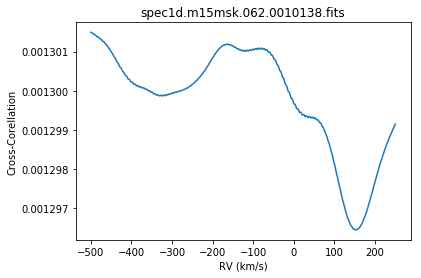

062.0010138 has Radial Velocity = -500
Shifting spectra 062.0010138 to rest frame
Normalizing spectra 062.0010138
Calculating weights...
Processing spectra for object: spec1d.m15msk.064.0010468.fits
Interpolating spectra #063.0010112
Restoring spectra #064.0010468
Applying telluric mask for spectra 063.0010112
Finding radial velocity from CCF for spectra #063.0010112
Calculating continuum...
Interpolating spectra #064.0010468


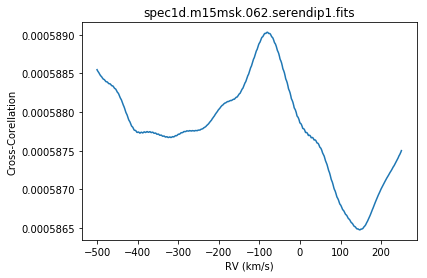

062.serendip1 has Radial Velocity = -80
Applying telluric mask for spectra 064.0010468
Calculating continuum...
Finding radial velocity from CCF for spectra #064.0010468
Shifting spectra 062.serendip1 to rest frame
Normalizing spectra 062.serendip1
Calculating weights...


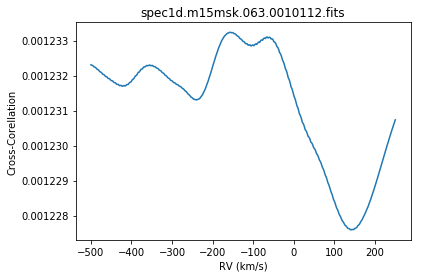

063.0010112 has Radial Velocity = -157
Shifting spectra 063.0010112 to rest frame
Normalizing spectra 063.0010112
Calculating weights...


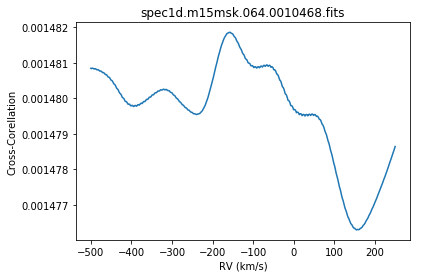

064.0010468 has Radial Velocity = -158
Shifting spectra 064.0010468 to rest frame
Normalizing spectra 064.0010468
Calculating weights...
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!
Calculating continuum...
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide


Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Completed processing of all spectra
Saving all processed spectra for m15 to m15_Horne.npz







In [6]:
'''
Code for reading in 1-d DEIMOS spectra reduced by the spec2d code:
http://deep.ps.uci.edu/spec2d/. Can process spectra from a single target
or from a list of targets sequentially.

This code:
1) Reads in 1-d DEIMOS spectra .fits files and concatenates spectra from the
red and blue CCDs.
2) Interpolates spectra onto the standard wavelength template for DEIMOS.
3) Outputs all object spectra in a .npz file.
'''

from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import multiprocessing
import utils

# # # Settings # # #


# DEIMOS Directory
DEIMOSDir = '/global/scratch/nathan_sandford/DEIMOS/'
# D-Payne Directory
D_PayneDir = utils.D_PayneDir
# Output directory for processed spectra
OutputDir = D_PayneDir + 'spectra/obs_spectra/'

'''
List of targets to process.
Note that 'm92' is missing and 'pegdig' includes data from two nights.
''' # 'm2', 'm13', 'm15','m71', 'ngc2419', 'ngc7006', 'pegdig', 'pegdig24', 'pegdig26', 'wlm' already done
targets = ['m15']

'''
Which method of fitting the DEIMOS spectrum do you want to use:
'Horne' or 'Bxspf'
'''
method = 'Horne'

'''
Do you want to plot cross correlation function?
'''
plot_flag = True

# Restore Wavelength Template
print('Restoring Wavelength Template')
wavelength_template = utils.load_wavelength_array()

# Calculate matrix of distances between wavelengths
print('Calculating matrix of distances between wavelengths...')
wavelength_diff_matrix \
    = wavelength_template[:, np.newaxis] - wavelength_template

# Restore DEIMOS continuum pixels
print('Restoring DEIMOS continuum pixels')
cont_reg = utils.load_deimos_cont_pixels()

# Restore telluric mask from Kirby+ 2008
print('Restoring telluric mask from Kirby+ 2008...')
kirby_2008_telluric = utils.get_spectral_mask_dict(name='kirby_2008_telluric')
mask = utils.generate_mask_from_dict(**kirby_2008_telluric)

# Restore spectral template of typical RGB star
print('Restoring spectral template...')
temp = np.load(D_PayneDir + '/other_data/typical_RGB_spectra.npz')
template_spec = temp['spec'][(wavelength_template > 8450) &
                             (wavelength_template < 8700)]
temp.close()

# Prepping cross-correlation function
print('Prepping cross-correlation calculation...')
wavelength_CaIItriplet = wavelength_template[(wavelength_template > 8450) &
                                             (wavelength_template < 8700)]
dv_grid = np.linspace(-500, 250, 750)
template_grid = np.empty((len(dv_grid), len(wavelength_CaIItriplet)))
for i, dv in enumerate(dv_grid):
    template_grid[i] = utils.doppler_shift(wavelength=wavelength_CaIItriplet,
                                           flux=template_spec, dv=dv)

def get_deimos_spectra(Obj, method, InputDir=None):
    '''
    Read in and concatenate red and blue spectra
    '''
    ObjHDUL = fits.open(InputDir + Obj)

    try:
        waveB = ObjHDUL[method+'-B'].data['LAMBDA'][0]
        waveR = ObjHDUL[method+'-R'].data['LAMBDA'][0]
        wave = np.concatenate((waveB, waveR))
    
        specB = ObjHDUL[method+'-B'].data['SPEC'][0]
        specR = ObjHDUL[method+'-R'].data['SPEC'][0]
        spec = np.concatenate((specB, specR))
    
        ivarB = ObjHDUL[method+'-B'].data['IVAR'][0]
        ivarR = ObjHDUL[method+'-R'].data['IVAR'][0]
        ivarB = 1e-16 * np.ones(len(ivarB))  # completely ignore blue channel
        ivar = np.concatenate((ivarB, ivarR))
        ivar[ivar == 0] = 1e-16  # Avoid np.inf in spec_err
    except KeyError:
        print('%s Missing %s spectra' % (Obj, method))
        wave, spec, ivar = np.zeros((3,len(wavelength_template)))
        

    RA = ObjHDUL[method+'-B'].header['RA_OBJ']
    Dec = ObjHDUL[method+'-B'].header['DEC_OBJ']
    try:
        RA_Dec = SkyCoord(RA+' '+Dec, unit=(u.hourangle, u.deg))
    except ValueError:
        print('Missing RA or Dec')
        RA_Dec = SkyCoord('00:00:01 00:00:01', unit=(u.hourangle, u.deg))
    return (wave, spec, ivar, RA_Dec)


def interpolate_deimos_spectra(wave, spec, spec_err):
    '''
    Interpolates a DEIMOS spectrum onto the default wavelength grid
    '''
    if len(wave) != 16250:
        spec = np.interp(wavelength_template, wave, spec)
        spec_err = np.interp(wavelength_template, wave, spec_err)
        wave = np.copy(wavelength_template)
    return(wave, spec, spec_err)


def fast_RV(Obj, spec, spec_err, plot=False):
    '''
    Quick radial velocity determination by cross-correlating observed spectrum
    with a template spectrum in the region around the Ca II triplet.
    '''

    # Consider only region around Ca II triplet
    temp_spec = spec[(wavelength_template > 8450) &
                     (wavelength_template < 8700)]
    temp_spec_err = spec_err[(wavelength_template > 8450) &
                             (wavelength_template < 8700)]

    # Cross-Correlate
    num = np.sum(template_grid * temp_spec / temp_spec_err, axis=1)
    den = np.sum(template_grid * template_grid / temp_spec_err, axis=1)
    xcorr = num / den

    # Naively take maximum of CCF
    dv = dv_grid[np.argmax(xcorr)]

    # Plot output
    if plot:
        plt.plot(dv_grid, xcorr)
        plt.xlabel('RV (km/s)')
        plt.ylabel('Cross-Corellation')
        plt.title('%s' % Obj)
        plt.show()

    return(dv)


def process_deimos_spectra(i):
    '''
    Processes all spectra in InputList
    '''
    Obj = ObjList[i]
    ObjNumber = Obj[14:-5]
    print('Processing spectra for object: %s' % Obj)

    print('Restoring spectra #%s' % ObjNumber)
    wave_temp, spec_temp, ivar_temp, RA_Dec = \
        get_deimos_spectra(Obj=Obj, method=method, InputDir=InputDir)

    print('Interpolating spectra #%s' % ObjNumber)
    wavelength, spec, spec_err = \
        interpolate_deimos_spectra(wave=wave_temp,
                                   spec=spec_temp,
                                   spec_err=(ivar_temp**-1))

    print('Applying telluric mask for spectra %s' % ObjNumber)
    spec_err[mask] = 1e16

    print('Finding radial velocity from CCF for spectra #%s' % ObjNumber)
    dv = fast_RV(Obj, spec, spec_err, plot=plot_flag)
    print('%s has Radial Velocity = %.0f' % (ObjNumber, dv))
    print('Shifting spectra %s to rest frame' % ObjNumber)
    spec = utils.doppler_shift(wavelength=wavelength, flux=spec, dv=-dv)

    print('Normalizing spectra %s' % ObjNumber)
    cont_spec = \
        utils.get_deimos_continuum(spec, spec_err=spec_err,
                                   wavelength=wavelength,
                                   cont_pixels=cont_reg,
                                   wavelength_diff_matrix=wavelength_diff_matrix)
    norm_spec = spec / cont_spec

    # Handle regions where continuum is zero
    spec_err[np.isnan(norm_spec)] = 1e16
    norm_spec[np.isnan(norm_spec)] = 0

    return(ObjNumber, wavelength, spec, norm_spec, spec_err, dv, RA_Dec)

for target in targets:
    print('Beginning reduction for %s' % target)
    
    # Input List of DEIMOS spectra to be processed for fitting
    InputDir = DEIMOSDir + 'U112_reduced/'+target+'/'
    InputList = InputDir + 'spec1d.'+target+'msk.txt'
    # File containing processed spectra
    OutputFile = target+'_'+method+'.npz'
    
    # Extract object names from input list
    print('Restoring list of %s objects' % target)
    temp = open(InputList, 'r')
    ObjList = temp.read().split('\n')[:-2]
    temp.close
    
    # Process the spectra
    print('Beginning processing of all spectra for %s' % target)
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    temp = pool.map(process_deimos_spectra, range(len(ObjList)))
    temp = list(zip(*temp))
    ObjNumber, wavelength, spec, norm_spec, spec_err, dv, RA_Dec = temp
    print('Completed processing of all spectra')
    
    # Save processed spectra
    print('Saving all processed spectra for %s to %s\n\n\n\n\n' % (target,OutputFile))
    np.savez(OutputDir + OutputFile, obj=ObjNumber, wavelength=wavelength,
             spec=spec, norm_spec=norm_spec, spec_err=spec_err, dv=dv, RA_Dec=RA_Dec)
    

In [ ]:
s